# Class imbalance in gradient boosting classification algorithms: 

## Application to experimental stroke data


### PyCon Ireland 2020
### Olga Lyashevska

<img src="pics/qrcode.png" width=20% class="left">

<img src="pics/paper3.png" width=50% class="left">

# Who am I?



<img src="pics/met.png" width = 60% class="center">

# Problem setting:

Medical datasets are often **imbalanced**, i.e. the number of positive and negative cases is not equal.

Ironically, we might be interested in occurrence of some rare disease or high risk patients.

When positive cases are rare, for example, 90% of patients without disease (**class 0**) and 10% with disease (**class 1**), conventional classification methods will typically have accuracy up to 90%.

# Why is that?



That's because most classification algorithms are **accuracy-driven** and aim to improve the **overall accuracy** of the model without accounting for uneven distribution of the majority and minority classes.

Even if all data points are predicted as 0’s, results still will be correct 90% of the time.

## Impact

The impact of class imbalance on classification performance can be detrimental. 

It results in failure to predict positive cases and in inability of classifier to predict cases when measures need to be taken (for example when we are dealing with stroke date).

# What is a stroke?

A stroke occurs when the blood supply to part of the brain is interrupted or reduced, depriving brain tissue of oxygen and nutrients. 
Within minutes, brain cells begin to die.


- 20% of cases are caused by a rupture or leakage from a blood vessel;
- 80% of cases are due to the formation of a blood clot in a vessel supplying blood to the brain (also known as a “ischemic stroke”).

<img src="pics/ischemicstroke.jpg" width = 30% alt="Paris" class="center">

# Why it matters?

- A stroke is a medical emergency and prompt treatment is crucial; 

- Early action can minimize brain damage and potential complications;

- A stroke is a leading cause of disability which drains our economy;

- 2,000 people die in Ireland per annum as a result of accute Ishemic stroke (Irish Heart Foundation, 2017).

Therefore it is crucial to gain knowledge into the **risk factors** for strokes in order to minimise them. However, stroke datasets are typically **imbalanced**.


# Objective:

To investigate risk factors for strokes and examine impact of variables such as 


- blood clot dimensions (length and diameter); 
- shape of the aortic arch; 
- heartbeat (normal, artrial fibrilation, steady) 





<img src="pics/bloodclot.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<img src="pics/aorticarch1.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">
<p style="clear: both;">
    

# Description of simulation system






<img src="pics/GvSi8m.png" width = 80% class="center">

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import sklearn
import time
import itertools
from sklearn.ensemble import partial_dependence, GradientBoostingClassifier
from sklearn import metrics, model_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import seaborn as sns

timestr = time.strftime("%Y-%m-%d-%H-%M-%S")
print("Created on: {}".format(timestr))

__author__ = "Olga Lyashevska"
__email__ = "olga.lyashevska@gmit.ie"
__status__ = "Development"


# read in data
data = pd.read_csv('./data/data.csv', index_col=0)

# code head and no head
data['Head'] = data.Branch.map({'lcca': 1,
                                'rcca': 1,
                                'lsub': 0,
                                'rsub': 0,
                                'descending': 0})

# To normalise distribution we eliminate blood clots above 10 cm
data = data[data.Length < 10]

# split data into X and y
y = data.Head.ravel()
# select all columns except Head, thrombin and Branch
X = data.loc[:, data.columns != 'Head']

# drop Thrombin, Branch
X.drop(['Thrombin', 'Branch'], axis=1, inplace=True)

# select columns to convert
cols = list(X.select_dtypes(include=['object']).columns.values)
cols

Created on: 2020-02-28-15-07-58


['Arch', 'Entry', 'Flowrate']

In [2]:
data.head(10)

,Thrombin,Diameter,Length,Branch,Arch,Rigid,Entry,Flowrate,Head
0,0nihu,3.74,8.47,lcca,model1,1,right,steady,1
1,0nihu,4.71,6.22,lsub,model1,1,right,steady,0
2,0nihu,3.42,5.57,rcca,model1,1,right,steady,1
3,0nihu,3.36,5.12,descending,model1,1,right,steady,0
4,0nihu,4.29,3.61,descending,model1,1,right,steady,0
5,0nihu,3.54,7.28,descending,model1,1,right,steady,0
6,0nihu,3.21,8.02,descending,model1,1,right,steady,0
7,0nihu,4.31,7.90,descending,model1,1,right,steady,0
8,0nihu,4.65,7.35,descending,model1,1,right,steady,0
9,0nihu,3.47,5.23,descending,model1,1,right,steady,0


## Class weights

In [33]:
classw = data['Head'].value_counts(normalize=True)
print('Class weights:\n {}'.format(classw))

Class weights:
 0    0.869926
1    0.130074
Name: Head, dtype: float64


13% of all clots go into head, 87% elsewehere.


## Length

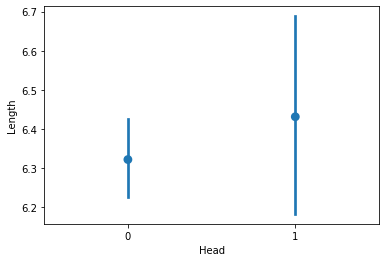

In [34]:
sns.pointplot(x="Head", y="Length", data=data, join=False)

Hypothesis: On overage longer clots seem to cause strokes.

## Diameter

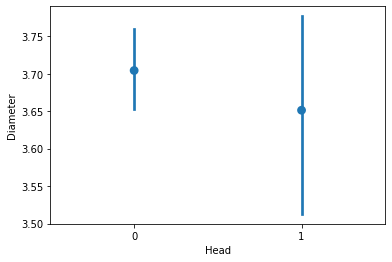

In [35]:
sns.pointplot(x="Head", y="Diameter", data=data, join=False)

Hypothesis: On average thinner clots seem to cause strokes.

## Arch

The aortic arch is the portion of the main artery that bends between the ascending and descending aorta. It leaves the heart and ascends, then descends back to create the arch.

<img src="pics/aorticarch1.jpg" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

In [36]:
data.Arch.value_counts(normalize=True)

model1    0.518450
model2    0.161439
model3    0.161439
model4    0.158672
Name: Arch, dtype: float64

## Model manufacture

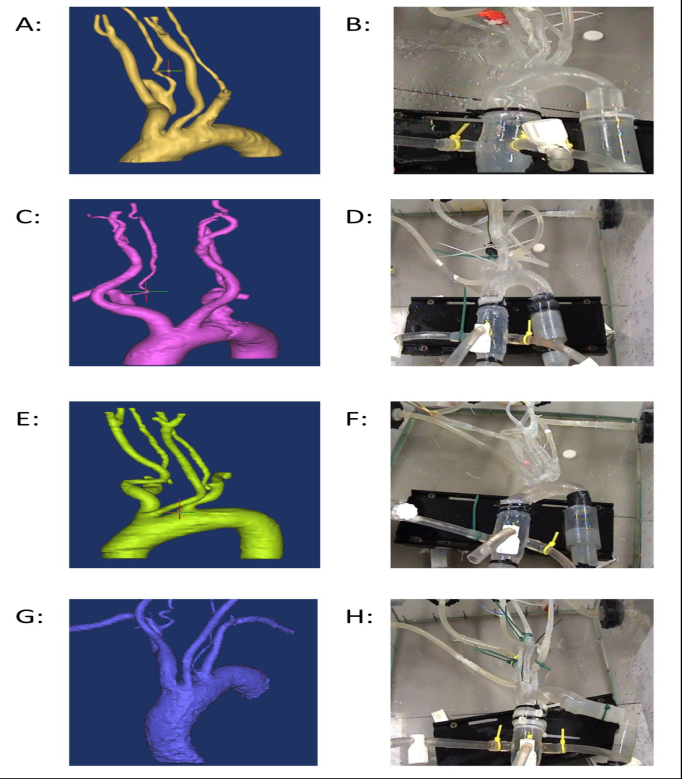

In [11]:
Image(filename='pics/OvOTun.png', width = 500, height=600)

# Methods:

1. Address class imbalance problem in order to achieve better classifier performance (in ROC space);

2. Apply classification algorithm (Gradient Boosting Classification Trees) to predict features contributing towards stroke;


## 1. Class Imbalance

Class-balanced data can generally be achieved by __undersampling__ the majority class or __oversampling__ the minority.

Synthetic Minority Oversampling TEchnique (SMOTE) is designed to generate new "synthetic" data that is coherent with the minority class distribution.

The minority class is oversampled by taking each minority class sample and introducing synthetic examples along the segments joining any/all of the k minority class nearest neighbors.

Depending upon the amount of oversampling required, neighbors from the k nearest neighbors are randomly chosen.






In [37]:
one_hot = pd.get_dummies(X[cols], drop_first=True)

# drop original cols
X.drop(cols, axis=1, inplace=True)

# join the encoded
X = X.join(one_hot)

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (1084, 10)
Shape of y: (1084,)


# Train/test data split

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5,
                                                                    random_state=13)
print('X_train:', X_train.shape, "\n"
      'X_test:', X_test.shape, "\n"
      "y_train:", y_train.shape, "\n"
      "y_test:", y_test.shape, "\n")

print("Before oversampling, counts of label '1': {}".format(sum(y_test == 1)))
print("Before oversampling, counts of label '0': {}".format(sum(y_test == 0)))

X_train: (542, 10) 
X_test: (542, 10) 
y_train: (542,) 
y_test: (542,) 

Before oversampling, counts of label '1': 74
Before oversampling, counts of label '0': 468


Data is imbalanced!

##  SMOTE oversampling

In [39]:
# SMOTE finds the k-nearest-neighbors for minority class observations
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = 1,
           random_state = None,
           k_neighbors = 5,  
           n_jobs = 1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
X_test_sm, y_test_sm = sm.fit_sample(X_test, y_test.ravel())
  
print("After OverSampling, counts of label '1': {}".format(sum(y_test_sm == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_test_sm == 0)))

After OverSampling, counts of label '1': 468
After OverSampling, counts of label '0': 468


Data is balanced!

## 2. Gradient Boosting Classification Trees

- Gradient boosting is a machine learning technique for regression and classification problems.
- It produces a prediction model in the form of an __ensemble of weak classifiers__, typically decision trees. 
- A weak classifiers is one whose error rate is only slightly better that random guessing. 
- Each successive model attempts to correct for the shortcomings of the combined boosted ensemble of all previous models.  
- A combination of individual models together create a more powerful new model.  



### Hyperparameter Tuning 

Hyper-parameters are parameters that are not directly learnt within estimators

- Max tree depth  - controls the maximum allowed level of interaction between variables in the model (2 no interaction between variables is allowed, 3 interaction between up to 2 variables, and so on) 

- Learning rate (shrinkage) - the rate of the gradient descent.

In [43]:
param_tune = {'max_depth': list(np.arange(1, 11)),
              'learning_rate': list(np.arange(start=0.001, stop=0.5, step=0.05))} 



## Grid - search

Exhaustive grid search generates candidates from a grid of parameter values

In [50]:
est_tune = GradientBoostingClassifier(n_estimators = 80, verbose = 0)
gs = model_selection.GridSearchCV(estimator = est_tune,
                                  param_grid = param_tune,
                                  cv = 5,
                                  n_jobs = 4,
                                  verbose = 1
                                  )
gs.fit(X_train_sm, y_train_sm)
print("Best model parameters are: {}".format(gs.best_params_))
gs.best_params_['subsample'] = 0.75

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 313 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 493 out of 500 | elapsed:   23.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   23.5s finished


Best model parameters are: {'learning_rate': 0.201, 'max_depth': 7}


## Model fitting

In [51]:
est_tune.set_params(**gs.best_params_)
est_tune.fit(X_train_sm, y_train_sm)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.201, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.75, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## Model diagnostics: Score 

In [53]:
# Print the score (R^2)
acc_train = est_tune.score(X_train_sm, y_train_sm)
acc_test = est_tune.score(X_test_sm, y_test_sm)

print('R^2 test: %.4f' % acc_test)

# mse = metrics.mean_squared_error(y_test, est_tune.predict(X_test))
# print('MSE: %.4f' % mse)


R^2 test: 0.5321


## Model diagnostics: Deviance

Text(0, 0.5, 'MSE')

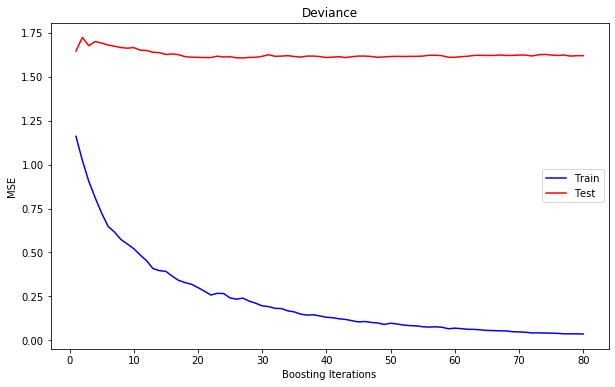

In [55]:
test_score = np.zeros((est_tune.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(est_tune.staged_predict(X_test)):
    test_score[i] = est_tune.loss_(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(est_tune.n_estimators) + 1,
         est_tune.train_score_, 'b-',
         label='Train')
plt.plot(np.arange(est_tune.n_estimators) + 1,
         test_score, 'r-',
         label='Test')
plt.legend(loc='right'); plt.xlabel('Boosting Iterations'); plt.ylabel('MSE')

## Feature importance

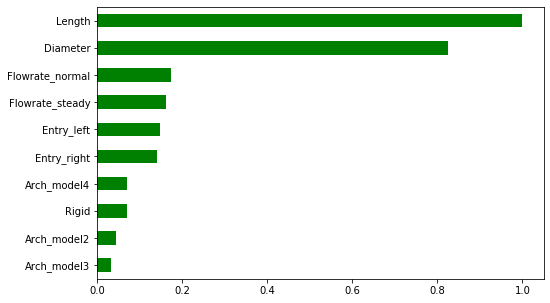

In [57]:
names = X.columns.values
fx_imp = pd.Series(est_tune.feature_importances_, index=names)
fx_imp /= fx_imp.max()  # normalize
fx_imp.sort_values(ascending=True).plot(kind='barh', figsize=(8, 5), color='g')


## Partial dependence plot

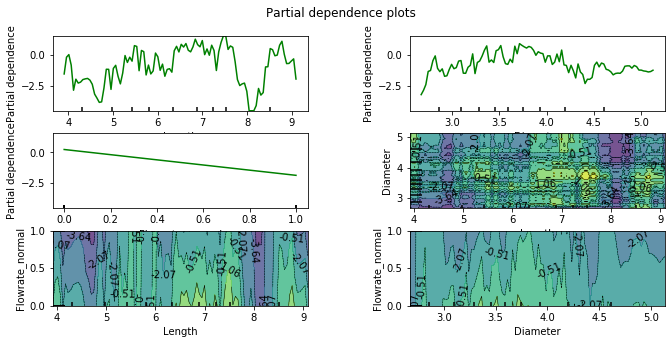

In [59]:
fx_imp.sort_values().index
fx_imp_2 = ['Length', 'Diameter', 'Flowrate_normal']
features = []
for i in range(1, len(fx_imp_2)):
    els = [list(x) for x in itertools.combinations(fx_imp_2, i)]
    features.extend(els)
fig, axs = partial_dependence.plot_partial_dependence(est_tune, X_train_sm, features, feature_names=list(X.columns.values), n_cols=2,figsize=(10, 5))
fig.suptitle('Partial dependence plots'); plt.subplots_adjust(top=0.9)

## Confusion Matrix

To describe performance of classification model we use confusion matrix
confusion matrix 2x2 dimensions, because it is a binary classification.
Non-diagonal element are innacurate predictions.


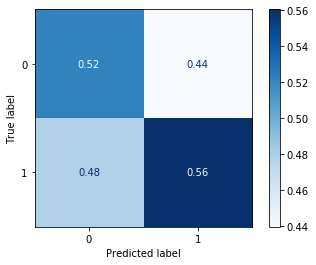

In [60]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(est_tune, X_test_sm, y_test_sm,
                    cmap=plt.cm.Blues,
                    normalize='pred')

## Receiver Operator Curve (ROC)

In a ROC curve the TP rate (Sensitivity) is plotted as function of the FP rate (100 - Specificity) for different cut-off points of a parameter. 

The area under the ROC curve is a measure of how well a parameter can distinguish between two outcomes Stroke/No Stroke. 

It shows the trade off between Sensitivity and Specificity.

Text(0.5, 0, 'False Positive Rate')

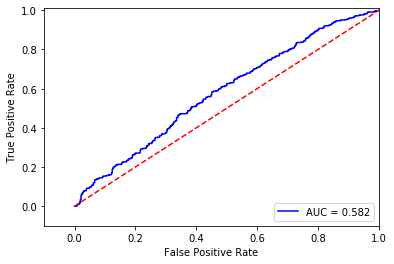

In [62]:
tmp = est_tune.fit(X_train_sm, y_train_sm.ravel())
y_pred_sample_score = tmp.decision_function(X_test_sm)
fpr, tpr, thresholds = metrics.roc_curve(y_test_sm, y_pred_sample_score)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc); plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--'); plt.xlim([-0.1, 1.0]); plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')

"""
The precision is the ability of the classifier not to label a sample as
positive if it is negative.

In binary classification:
    recall of the positive class is also known as “sensitivity”
    recall of the negative class is “specificity”.
"""


## Classification report
- __precision__ is the ability of a classiifer not to label an instance positive that is actually negative (the ratio of true positives to the sum of true and false positives); 
- __recall__ is the ability of a classifier to find all positive instances (the ratio of true positives to the sum of true positives and false negatives). 

In [64]:
print('Classification report: \n', metrics.classification_report(y_test_sm, est_tune.predict(X_test_sm)))

Classification report: 
               precision    recall  f1-score   support

           0       0.52      0.77      0.62       468
           1       0.56      0.29      0.39       468

    accuracy                           0.53       936
   macro avg       0.54      0.53      0.51       936
weighted avg       0.54      0.53      0.51       936



## Conclusions:

- Blood clots dimensions are more important than a patient’s aortic arch geometry;
- There seems to be a positive contribution of clot length and diameter on stroke, but up too certain level.
- There is a complex interaction between the clot length and diameter





# References 

Chawla NV, Bowyer KW, Hall LO et al. Smote: Synthetic minority over-sampling technique.Journalof Artificial Intelligence Research2002; 16: 321–357 https://arxiv.org/abs/1106.1813

Lemaitre G, Nogueira F and Aridas CK. Imbalanced-learn: A python toolbox to tackle the curse ofimbalanced datasets in machine learning.Journal of Machine Learning Research2017; 18(17): 1–5.URL http://jmlr.org/papers/v18/16-365.html